# SBD on nuclear shell model

In [5]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.utils_quasiparticle_approximation import HardcoreBosonsBasis
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.fermi_hubbard_library import FemionicBasis
import numpy as np
from typing import List, Dict
from scipy.linalg import expm
import scipy
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
from scipy.optimize import minimize
from scipy import sparse

file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)

In [ ]:
nparticles_a=4
nparticles_b=2 # Berillium

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

Exact solution:

In [7]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

####
H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
basis = NSMHamiltonian.basis # basis
###

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1) # exact solution, later to confront
psi0 = psi0.reshape(-1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.52it/s]
1424it [00:02, 668.16it/s]


[-39.4534158]
total_m= 4.174178364069192e-17
dimension= 51


Voglio una classe Nuclear shell model sqd ansatz (trova un nome migliore hahah), i suoi parametri sono H e la base oppure numero particelle e per il resto fa automatico. Voglio i seguenti metodi:
- Inizializzazione stato con lo stato della base con minore energia
- Creazione operator pool
- compute state con produttoria delle unitarie ottenute esponenziando la somma degli operatori nell'operator pool sommati con il loro complesso coniugato fatta con scipy exp multiply applicato a stato precedente (se prima iter a quello dell'inizializzazione)
- fare SQD con quello stato e stimare energia con SQD

In secondo momento sarà da aggiungere anche minimizzazione energia!!!


In [132]:
import itertools
from scipy.optimize import dual_annealing

def genera_ij(N): # crea lista indici (0,1),(0,2),..,(0,N-1),(1,2),....,(N-2,N-1) con N input
    return [(i, j) for i in range(N) for j in range(i + 1, N)]


def genera_i1i2j1j2(N):
    """
    Restituisce una lista di tuple (i1, i2, j1, j2) con valori unici tra 0 e N-1
    ed evita ripetizioni causate da permutazioni interne.
    """
    result = set()
    indices = range(N)

    for comb in itertools.combinations(indices, 4):  # scegli 4 indici distinti
        for split in itertools.combinations(comb, 2):  # scegli 2 per il primo "pair"
            # ottieni i1, i2 dal primo gruppo; j1, j2 dagli altri due
            i1, i2 = sorted(split)
            rest = [x for x in comb if x not in (i1, i2)]
            j1, j2 = sorted(rest)

            # crea una tupla canonica: (i1, i2, j1, j2)
            tup = (i1, i2, j1, j2)
            result.add(tup)

    return sorted(result)


class NSM_SQD_circuit_ansatz:

    def __init__(self, file_name = 'data/cki', nparticles_a=4, nparticles_b=2,M=None, samples = 20, batches =100, train_steps = 10):
        self.M = M
        if self.M == 0:
            # compute the NSM Hamiltonian and the basis
            NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
            print('size=',size_a+size_b,size_b)
            NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

                NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            NSMHamiltonian.get_hamiltonian()

        else:
            # compute the NSM Hamiltonian and the basis
            NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[])
            print('size=',size_a+size_b,size_b)
            NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

                NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            NSMHamiltonian.get_hamiltonian()

        ####
        self.H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
        self.basis = NSMHamiltonian.basis # basis
        ###

        self.l = len(self.basis[0]) # lunghezza un elemento base
        self.operator_pool = {} # op pool as dict where key is (i,j)
        self.operator_pool_list = [] # op pool as list 
        self.psi = np.zeros(len(self.basis))
        self.E = 0.

        self.seed = 1024

        self.samples = samples # number of samples for sqd energy estimation
        self.batches = batches # different batches for sqd to make an average of the energy
        self.train_steps = train_steps # steps in optimization

    def initialize_state_v1(self): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis))  
        diag = self.H.diagonal()
        min_state_idx = diag.argmin()
        self.psi[min_state_idx] = 1. 
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag.min()
        return None

    def initialize_state_v2(self,ns): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis)) 
        diag = self.H.diagonal()
        min_indices = np.argsort(diag)[:ns]
        self.psi[min_indices] = 1. / np.sqrt(ns)
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag[min_indices].mean()
        return None

    def initialize_state_v3(self): # ref state is the element of the basis with the minimum energy
        self.psi = vettore = np.random.uniform(0, 1, len(self.basis))
        self.psi /= np.linalg.norm(self.psi)
        self.E = self.psi.transpose().conj() @ self.H @ self.psi
        return None




    def miquel_constrainer(self,idxs:List[int]):
        
        if SPS.projection_conservation(idxs=idxs):
            if HardcoreBosonsBasis(self.basis).charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
                op=HardcoreBosonsBasis(self.basis).adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
                diag_op = sparse.diags(op.diagonal())

                non_diag_op =np.abs( op - diag_op)
                if not(np.isclose(non_diag_op.sum(),0.)):
                    condition=True
                else:
                    condition=False
            
            else:
                condition=False
        else:
            condition=False
                    
        return condition


    def miquel_constrainer_2(self,idxs:List[int]):
        _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
        _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
        _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
        _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
        
        j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
        j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
        #print(j_tot_i,j0,j1)
        if tz0==tz1:
            if j0==j1:
                j_tot_i=[j for j in j_tot_i if j % 2==0 ]
                #print('i=',j_tot_i,j0,j1)
            if j2==j3:
                j_tot_f=[j for j in j_tot_f if j % 2==0 ]
                #print('f=',j_tot_f,j2,j3,'\n')
            if set(j_tot_i) & set(j_tot_f):
                
                
                condition=True
            else:
                
                condition=False

        else:

        
            if set(j_tot_i) & set(j_tot_f):
                condition=True
            else:

                condition=False


                
        return condition
    
    def miquel_constrainer_3(self,idxs:List[int]):
        condition=False
        p=np.random.uniform(0,1)
        if SPS.projection_conservation(idxs=idxs):
            if p<1:
                condition=True
                    
        return condition


    def create_operator_pool_twobody_symmetry(self): # nella pool two body op che rispettano i miquel constraints
        self.operator_pool:Dict={}
        self.operator_pool = HardcoreBosonsBasis(self.basis).set_operator_pool(operator_pool=self.operator_pool,conditions=[SPS.projection_conservation,self.miquel_constrainer_2,self.miquel_constrainer,self.miquel_constrainer_3],nbody='two')
        self.operator_pool_list = list(self.operator_pool.values())
        np.random.seed(self.seed) 
        self.weights = np.zeros(len(self.operator_pool))#np.random.uniform(-1.3, 1.3, size=len(self.operator_pool))
        return None

    def forward(self, weights): # compute psi
        psi = self.psi.copy()
        if self.weights is not(None):
            
            for i, w in enumerate(weights):
                # print(np.conj(expm(self.weights[i] * op).T) @ expm(self.weights[i] * op))
                psi = scipy.sparse.linalg.expm_multiply( (0. + 1j) * w * self.operator_pool_list[i],psi) 
                psi = psi / np.linalg.norm(psi)

        return psi

    def SQD(self, weights): #output è energia stimata con SQD (compute energy functional)
        psi = self.forward(weights)
        prob = (np.conjugate(psi) * psi).real # .real needed to change data type from complex to float
        Ham = self.H.copy()
        np.random.seed(self.seed) # seed con cui calcolo il vettore random i cui elementi sono i seed dei diversi batch
        seeds = np.random.randint(1, 30002, size=self.batches)
        e = np.zeros(self.batches)
        self.psi_batches=np.zeros((self.batches,self.psi.shape[0]))
        for k,s in enumerate(seeds):
            np.random.seed(s)
            #print('non zero prob=',np.nonzero(prob)[0].shape[0])
            if np.nonzero(prob)[0].shape[0]<self.samples:
                selection = np.random.choice(len(self.basis), size=np.nonzero(prob)[0].shape[0], replace=False, p=prob)

            else:
                selection = np.random.choice(len(self.basis), size=self.samples, replace=False, p=prob)
            # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))
            #print('selection length=',len(selection))
            # for a,idx_a in enumerate(selection):
            #     for b,idx_b in enumerate(selection):
            #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
            if len(selection)!=1:    
                effective_hamiltonian=  Ham.tocsr()[selection,:][:,selection]

                value,eighvec = eigsh(effective_hamiltonian, k=1, which="SA", maxiter=int(1E6), ) # Diagonalization of reduced H
                e[k]=value[0]
                self.psi_batches[k,selection]=eighvec[:,0]
            
            else:
                e[k]=Ham[selection[0],selection[0]]
            
        self.variance=np.std(e)
        return np.average(e)
    
    def cobyla_callback(self, x):
        # Callback function for COBYLA (optional, for printing intermediate results)
        print(f"Current COBYLA weights: {np.linalg.norm(x)}, SQD: {self.SQD(x)} Variance energy {self.variance}")

    def optimization(self):
        # bounds = [(-5, 5)] * len(self.weights)  # You must define appropriate bounds for each weight

        # for i in range(self.train_steps):
        #     # Simulated Annealing optimization
        #     res = dual_annealing(self.SQD, bounds=bounds, callback=self.annealing_callback)

        #     self.weights = res.x  # update weights
        #     self.E = self.SQD(self.weights)
        #     self.psi = self.forward(self.weights)

        #     print(i)
        #     print('Optimization Success =', res.success)
        #     print('Energy =', self.E)
        #     print(res.message)
            
            
        for i in range(self.train_steps):
            # COBYLA optimization
            # initial_guess = self.weights if i == 0 else self.weights # Use current weights as initial guess
            res = minimize(
                self.SQD,
                x0=self.weights, # Initial guess for the weights
                method='COBYLA',
                callback=self.cobyla_callback, # Optional callback
                options= {
                    'maxiter': 100,      # Maximum number of iterations
                    'rhobeg': 0.1,       # Initial trust region radius (larger value = larger initial steps)
                    'rhoend': 1e-4       # Final trust region radius (smaller value = more precise final steps)
                } # You can adjust maxiter and other options
            )

            self.weights = res.x  # update weights
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print(f'\n--- Training Step {i+1} ---')
            print('Optimization Success =', res.success)
            print('Energy (SQD) =', self.E)
            print('Message =', res.message)
            print('Current weights =', self.weights)
            print('Number of function evaluations =', res.nfev)


    def annealing_callback(self,x, f, context,*args):
        print('mario')
        print(f"Step context: {context} | Energy: {f} \n")
        self.weights=x.copy()
        #print(f"Weights: {x}\n")
        

In [140]:
m = NSM_SQD_circuit_ansatz(M=0,samples=30, train_steps=10) # nb da samples = 48 da e esatta se si parte da prob esatta
m.initialize_state_v1()

m.create_operator_pool_twobody_symmetry()

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.51it/s]
1424it [00:02, 662.80it/s]


In [141]:
print(len(m.operator_pool))
print(m.weights)

145
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [142]:
print(len(m.operator_pool_list))

m.psi
m.E

145


np.float64(-28.96475000000002)

In [143]:
m.SQD(np.zeros(m.weights.shape))

np.float64(-28.964750000000027)

In [144]:
m.optimization()

Current COBYLA weights: 0.1, SQD: -29.47973708507314 Variance energy 6.9346204497631214e-15
Current COBYLA weights: 0.14142135623730953, SQD: -31.14598584827646 Variance energy 6.598872780119333e-15
Current COBYLA weights: 0.17320508075688776, SQD: -31.14598584827646 Variance energy 7.315485206751049e-15
Current COBYLA weights: 0.17320508075688776, SQD: -32.933592447668104 Variance energy 6.51223174224333e-15
Current COBYLA weights: 0.2, SQD: -32.933592447668104 Variance energy 5.81604295168777e-15
Current COBYLA weights: 0.2, SQD: -32.933592447668104 Variance energy 6.4733523992858716e-15
Current COBYLA weights: 0.2, SQD: -32.933592447668104 Variance energy 6.925513918651634e-15
Current COBYLA weights: 0.2, SQD: -32.933592447668104 Variance energy 6.740800259667266e-15
Current COBYLA weights: 0.2, SQD: -33.599165908880614 Variance energy 1.125711400913677e-14
Current COBYLA weights: 0.223606797749979, SQD: -33.63971300408655 Variance energy 1.0198206790624429e-14
Current COBYLA weight

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

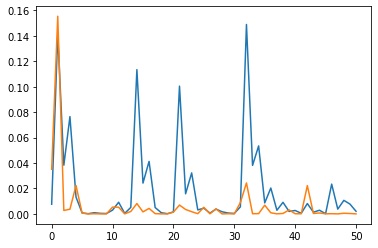

In [145]:
probb = (np.conjugate(m.forward(m.weights)) * m.forward(m.weights)).real

prob_samples=np.average((np.conjugate(m.psi_batches) * m.psi_batches),axis=0).real

plt.plot(probb)
plt.plot(prob_samples)
plt.show()

[0.3 0.3 0.  0.3 0.  0.1 0.  0.  0.2 0.3 0.1 0.2 0.2 0.  0.1 0.2 0.1 0.
 0.1 0.2 0.  0.2 0.1 0.3 0.  0.  0.2 0.3 0.  0.  0.2 0.1 0.  0.1 0.  0.1
 0.  0.4 0.1 0.  0.1 0.  0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.2 0.  0.1
 0.  0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.  0.  0.1
 0.  0.  0.3 0.  0.  0.  0.  0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ]


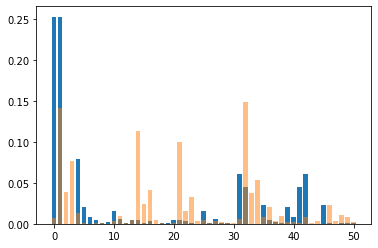

In [147]:
plt.bar(np.arange(psi0.shape[0]),(np.conjugate(psi0) * psi0).real)

plt.bar(np.arange(m.psi.shape[0]),probb,alpha=0.5)

print(m.weights)